## Import and Settings

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col, expm1, abs, avg, lit, round
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_PATH = "../../models/regression/gbt_price_log_v1"  

DATA_PATH = "../../data/cleaned/regression_data"

## Initialize Spark

In [2]:
spark = SparkSession.builder \
    .appName("Amazon Price Prediction") \
    .config("spark.driver.memory", "8g") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")


## Load Model and Data

In [3]:
print(f"Loading model from: {MODEL_PATH}...")
loaded_model = PipelineModel.load(MODEL_PATH)
print("Model loaded successfully!")

print(f"Loading data from: {DATA_PATH}...")
df = spark.read.parquet(DATA_PATH)

df = df.withColumn("price", col("price").cast("float")) \
       .filter(col("price") > 0)

_, test_data = df.randomSplit([0.8, 0.2], seed=42)
print(f"Test data count: {test_data.count()} rows")

Loading model from: ../../models/regression/gbt_price_log_v1...
Model loaded successfully!
Loading data from: ../../data/cleaned/regression_data...
Test data count: 139938 rows


In [4]:
from pyspark.sql.functions import col, size, length, when

has_array_features = [f.dataType for f in df.schema.fields if f.name == "features"] # checks the data type of the features column and creates a new column features_count
if str(has_array_features[0]).startswith("ArrayType"):
    df = df.withColumn("features_count", size(col("features")))
else:
    if "features_count" not in df.columns and "features" in df.columns:
         df = df.withColumn("features_count", length(col("features")))

In [5]:
required_cols = ["rating_number", "average_rating", "main_category", "price"]

In [6]:
if "features_count" in df.columns: required_cols.append("features_count")
if "desc_len" in df.columns: required_cols.append("desc_len")

df_clean = df.dropna(subset=required_cols)

In [7]:
df_clean = df_clean.withColumn("title_len", length(col("title")))

In [8]:
from pyspark.sql.functions import length, col, count

store_counts = df_clean.groupBy("store").agg(count("*").alias("store_freq"))

In [9]:
df_improved = df_clean.join(store_counts, on="store", how="left")
df_improved = df_improved.na.fill(0, subset=["store_freq", "features_count", "title_len"])

In [10]:
from pyspark.sql.functions import broadcast

df_improved = df_clean.join(broadcast(store_counts), on="store", how="left")

cols_to_fill = ["store_freq", "title_len", "average_rating", "rating_number"]
if "features_count" in df_improved.columns: cols_to_fill.append("features_count")
if "desc_len" in df_improved.columns: cols_to_fill.append("desc_len")

df_improved = df_improved.na.fill(0, subset=cols_to_fill)

df_improved = df_improved.filter(col("title").isNotNull())
df_improved.cache()

DataFrame[store: string, parent_asin: string, title: string, main_category: string, average_rating: double, rating_number: bigint, features: array<string>, description: array<string>, price: float, main_category_label: string, features_count: int, title_len: int, store_freq: bigint]

In [11]:
from pyspark.sql.functions import log1p, expm1, col
from pyspark.ml.regression import GBTRegressor 
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, StopWordsRemover

df_log = df_improved.withColumn("label", log1p(col("price")))

In [16]:
_, test_data = df_log.randomSplit([0.8, 0.2], seed=42)

In [17]:
print("Running predictions...")
predictions = loaded_model.transform(test_data)

print("Converting log-predictions back to real prices...")
predictions = predictions.withColumn("predicted_price", expm1(col("prediction")))

from pyspark.sql.functions import when
predictions = predictions.withColumn(
    "predicted_price", 
    when(col("predicted_price") < 0, 0.01).otherwise(col("predicted_price"))
)

predictions.select("title", "price", "predicted_price").show(5, truncate=False)

Running predictions...
Converting log-predictions back to real prices...
+-------------------------------------------------------------------------------+------+------------------+
|title                                                                          |price |predicted_price   |
+-------------------------------------------------------------------------------+------+------------------+
|Warhammer 40k Adeptus Mechanicus Codex                                         |22.41 |17.730866095623913|
|[ST125] 2 Piece VVT-I DOHC Vinyl Sticker JDM Stickers 2JZ Supra Corrolla SILVER|5.99  |5.794295090694468 |
|Analog/Dual Shock Controller - Emerald                                         |57.77 |31.35317626681251 |
|Beetle Adventure Racing                                                        |43.98 |29.378666176271825|
|Wave Race 64 (Japan)                                                           |180.09|29.892769364260023|
+--------------------------------------------------------------

## Calculate Metrics

In [19]:
predictions = loaded_model.transform(test_data)

predictions = predictions.withColumn("prediction_price", expm1(col("prediction")))

r2_eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
print(f"R2 (Log Scale): {r2_eval.evaluate(predictions):.4f}")

rmse_eval = RegressionEvaluator(labelCol="price", predictionCol="prediction_price", metricName="rmse")
mae_eval = RegressionEvaluator(labelCol="price", predictionCol="prediction_price", metricName="mae")

print(f"RMSE (Real $): {rmse_eval.evaluate(predictions):.2f}")
print(f"MAE (Real $):  {mae_eval.evaluate(predictions):.2f}")

predictions.select("title", "price", "prediction_price").show(5, truncate=False)

R2 (Log Scale): 0.3104
RMSE (Real $): 187.57
MAE (Real $):  45.27
+-------------------------------------------------------------------------------+------+------------------+
|title                                                                          |price |prediction_price  |
+-------------------------------------------------------------------------------+------+------------------+
|Warhammer 40k Adeptus Mechanicus Codex                                         |22.41 |17.730866095623913|
|[ST125] 2 Piece VVT-I DOHC Vinyl Sticker JDM Stickers 2JZ Supra Corrolla SILVER|5.99  |5.794295090694468 |
|Analog/Dual Shock Controller - Emerald                                         |57.77 |31.35317626681251 |
|Beetle Adventure Racing                                                        |43.98 |29.378666176271825|
|Wave Race 64 (Japan)                                                           |180.09|29.892769364260023|
+---------------------------------------------------------------------

## Visualization

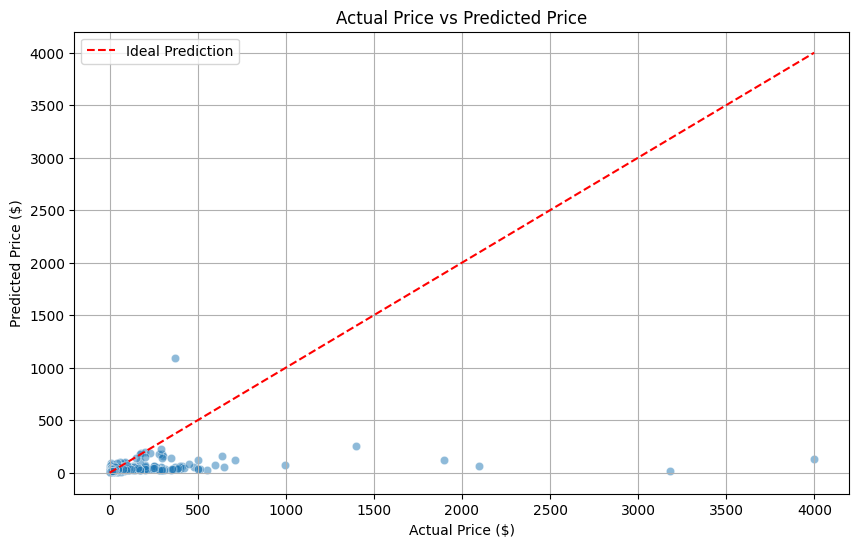

In [21]:
sample_pdf = predictions.select("price", "prediction_price").sample(False, 0.1).limit(1000).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="prediction_price", data=sample_pdf, alpha=0.5)

max_val = max(sample_pdf["price"].max(), sample_pdf["prediction_price"].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Prediction')

plt.title("Actual Price vs Predicted Price")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.legend()
plt.grid(True)
plt.show()